In [193]:
import json
import smart_open
import pandas as pd
import os

FIGURE_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/figures"
TABLES_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/tables"

# RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"
# MODEL_PATH = "olmo/1b/olmo-small-dolma-150B-mcli-results"
RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"
MODEL_PATH = "pythia/1b"

model_path = os.path.join(RESULTS_DIR, MODEL_PATH)

domains_with_subdomains = set()
for sheet_name in os.listdir(model_path):
    if sheet_name.endswith("subdomains.jsonl.gz") and not sheet_name.startswith("bits_per_byte"):
        domains_with_subdomains.add("_".join(sheet_name.split("_")[2:-1]))
    # print(sheet_name)

name_to_display = {
    'ppl_c4_en': 'C4',
    'ppl_falcon-refinedweb': 'Falcon',
    'ppl_mc4': 'MC4',
    'ppl_ptb': 'PTB',
    'ppl_wikitext_103': 'WikiText-103',
    'ppl_redpajama': 'RedPajama',
    'ppl_dolma-v1_5': 'Dolma V1.5',
    'ppl_pile': 'The Pile',
    'ppl_c4_100_domains': 'C4 100 Domains',
    'ppl_dolma_100_programing_languages': '100 PLs',
    'ppl_dolma_100_subreddits': '100 Subreddits',
    'ppl_ice_fixed': 'ICE',
    'ppl_m2d2_s2orc_unsplit': 'M2D2 S2ORC',
    'ppl_m2d2_wikipedia_unsplit': 'M2D2 Wikipedia',
    'ppl_manosphere_meta_sep': 'Manosphere',
    'ppl_twitterAAE_HELM_fixed': 'Twitter AAE',
    'model': 'Model',
    'model_size': 'Model Size',
    'split': 'Split',
    'tokens_seen': 'Tokens Seen',
    'training_dataset': 'Training Dataset',
    'training_steps': 'Training Steps'
}




shared_cols = {
 'model',
 'model_size',
 'split',
 'tokens_seen',
 'training_dataset',
 'training_steps'
 }

non_domain_cols = {
    "date",
    "model",
    "model_kwargs",
    "full_model",
    "task",
    "processing_time",
    "num_instances",
    "tango_workspace",
    "tango_step",
    "model_max_length",
    "max_batch_tokens",
    "batch_size",
    "limit",
    "split",
    "random_subsample_seed",
    "model_size",
    "training_steps",
    "tokens_seen",
    "training_dataset"
}

def standardize_model_metadata(row):
    if row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-dolma-150B-mcli'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'model_kwargs' in row:
            assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
            del row['model_kwargs']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'Dolma V1.5'
    elif row['model'].startswith('EleutherAI/pythia-1b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 805736448 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    else:
        # pass
        raise ValueError(f"Unknown model: {row['model']}")
    return row

def read_jsonl(path):
    with smart_open.open(path, 'rt') as fin:
        for line in fin:
            data = standardize_model_metadata(json.loads(line))
            yield data

fringe_domains = {
    'ppl_manosphere_meta_sep',
    'ppl_4chan_meta_sep',
    'ppl_gab'
}

domains_without_subdomains = set(pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))['task']) - domains_with_subdomains
domains_without_subdomains_clean = set(d for d in domains_without_subdomains if all(fringe_domain not in d for fringe_domain in fringe_domains))
domains_with_subdomains_clean = set(domains_with_subdomains) - fringe_domains

results_files_all = os.listdir(model_path)
results_files_clean = [f for f in results_files_all if all(fringe_domain not in f for fringe_domain in fringe_domains)]

In [2]:

ppl_redpajama_token_count_avg_logits = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_redpajama_token_count_avg_logits.jsonl.gz")))
ppl_redpajama_token_count_avg_logits.head()
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.jsonl.gz")))
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains
# ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
# ppl_metrics.head()

,model,subdomain,token,count,avg_logits,model_size,training_steps,tokens_seen,training_dataset
0,pythia,redpajama__books,analog,1,-18.806479,805736448,10000,20971520000,The Pile
1,pythia,redpajama__books,ou,1,-17.316435,805736448,10000,20971520000,The Pile
2,pythia,redpajama__books,Johnny,1,-16.327814,805736448,10000,20971520000,The Pile
3,pythia,redpajama__books,eclipse,1,-16.155434,805736448,10000,20971520000,The Pile
4,pythia,redpajama__books,bans,1,-16.144665,805736448,10000,20971520000,The Pile


In [80]:
from functools import reduce

def make_subdomain_of_task(model_path, task_names, metric_name):
    ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
    dfs = []
    assert set(task_names) <= set(ppl_metrics['task'])
    for task_name in task_names:
        task_df = ppl_metrics[ppl_metrics['task'] == task_name]
        new_df = task_df[list(shared_cols)].copy()
        new_df[task_name] = task_df[metric_name]
        dfs.append(new_df)
    
    return dfs

def get_metric_for_all_subdomains(model_path, sheet_names, metrics_name, include_non_subdomain_tasks=None, provided_dfs=None):
    dfs = [] if provided_dfs is None else provided_dfs
    if include_non_subdomain_tasks:
        dfs.extend(make_subdomain_of_task(model_path, include_non_subdomain_tasks, metrics_name))
    for k in sheet_names:
        if not k.endswith('subdomains.jsonl.gz'):
            continue
        if k.startswith(metrics_name):
            df = pd.DataFrame(read_jsonl(os.path.join(model_path, k)))
            
            df = df[list(df.columns.difference(non_domain_cols - shared_cols))]
            dfs.append(df)
    
    # join all the dfs on the domain cols, by concatenating the domain cols
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), dfs)
    return merged_df

def get_metric_weighted_by_subdomains(all_subdomains_df, subdomain_weights, task_name):
    domain_cols = list(set(all_subdomains_df.columns) - shared_cols)
    new_df = all_subdomains_df[list(shared_cols)].copy()
    # subdomain_weights = {col_name: weight} so apply this to respective columns
    for col_name, weight in subdomain_weights.items():
        all_subdomains_df[col_name] = all_subdomains_df[col_name] * weight
    new_df[task_name] = all_subdomains_df[domain_cols].sum(axis=1)

    return new_df

def get_avg_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['avg_over_subdomains'] = df[domain_cols].mean(axis=1)
    return new_df

def get_median_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['median_over_subdomains'] = df[domain_cols].median(axis=1)
    return new_df

def get_win_rate_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['win_rate_over_subdomains'] = df.apply(lambda row: sum(row[domain_cols] == df[domain_cols].min()), axis=1) / len(domain_cols)
    return new_df

# def get_win_rate_over_all_subdomains_by_bin(df, bin_measure, bin_size):
#     domain_cols = list(set(df.columns) - shared_cols)
#     max_bin = df[bin_measure].max()
#     min_bin = df[bin_measure].min()
#     new_df = []
#     for i in range(min_bin, max_bin, bin_size):
#         bin_rows = df[(df[bin_measure] >= i) & (df[bin_measure] < i + bin_size)].copy()
#         if len(bin_rows) < 2:
#             print((i, i + bin_size))
#             continue
#         # check that bin has no repeats of the same model
#         assert len(bin_rows) == len(set(bin_rows['model']))
#         bin_rows[f'win_rate_in_bin'] = bin_rows.apply(lambda row: sum(row[domain_cols] == bin_rows[domain_cols].min()), axis=1) / len(domain_cols)
#         bin_rows[f'bin_{bin_measure}'] = (i, i + bin_size)
#         new_df.append(bin_rows)
#     new_df = pd.concat(new_df)
#     return new_df

def get_win_rate_over_all_subdomains_by_nearest(df, nearest_measure, max_distance):
    domain_cols = list(set(df.columns) - shared_cols)
    # sort df by nearest measure
    df = df.sort_values(by=[nearest_measure])
    # iterate over each row
    new_df = []
    row_buffer = []
    for i, row in df.iterrows():
        if len(row_buffer) == 0:
            row_buffer.append(row)
            continue
        elif row['model'] != row_buffer[0]['model']:
            row_buffer.append(row)
            continue
        else:
            row_df = pd.DataFrame(row_buffer)
            if (row_df[nearest_measure].max() - row_df[nearest_measure].min() > max_distance):
                print(row_df[list(shared_cols)])
            if len(row_buffer) >1 and (row_df[nearest_measure].max() - row_df[nearest_measure].min() <= max_distance):
                assert len(row_df) == len(set(row_df['model']))
                row_df[f'win_rate_with_nearest'] = row_df.apply(lambda row: sum(row[domain_cols] == row_df[domain_cols].min()), axis=1) / len(domain_cols)
                new_df.append(row_df)
            row_buffer = []
            row_buffer.append(row)
    
    new_df = pd.concat(new_df)
    return new_df



    

In [77]:
domains_with_subdomains

{'ppl_c4_100_domains',
 'ppl_dolma-v1_5',
 'ppl_dolma_100_programing_languages',
 'ppl_dolma_100_subreddits',
 'ppl_ice_fixed',
 'ppl_m2d2_s2orc_unsplit',
 'ppl_m2d2_wikipedia_unsplit',
 'ppl_manosphere_meta_sep',
 'ppl_pile',
 'ppl_redpajama',
 'ppl_twitterAAE_HELM_fixed'}

In [87]:
all_subdomains_df = get_metric_for_all_subdomains(model_path, ['ppl_token_ppl_redpajama_subdomains.jsonl.gz'], "ppl", [])
set(all_subdomains_df.columns)-shared_cols

{'arxiv', 'books', 'c4', 'commoncrawl', 'github', 'stackexchange', 'wikipedia'}

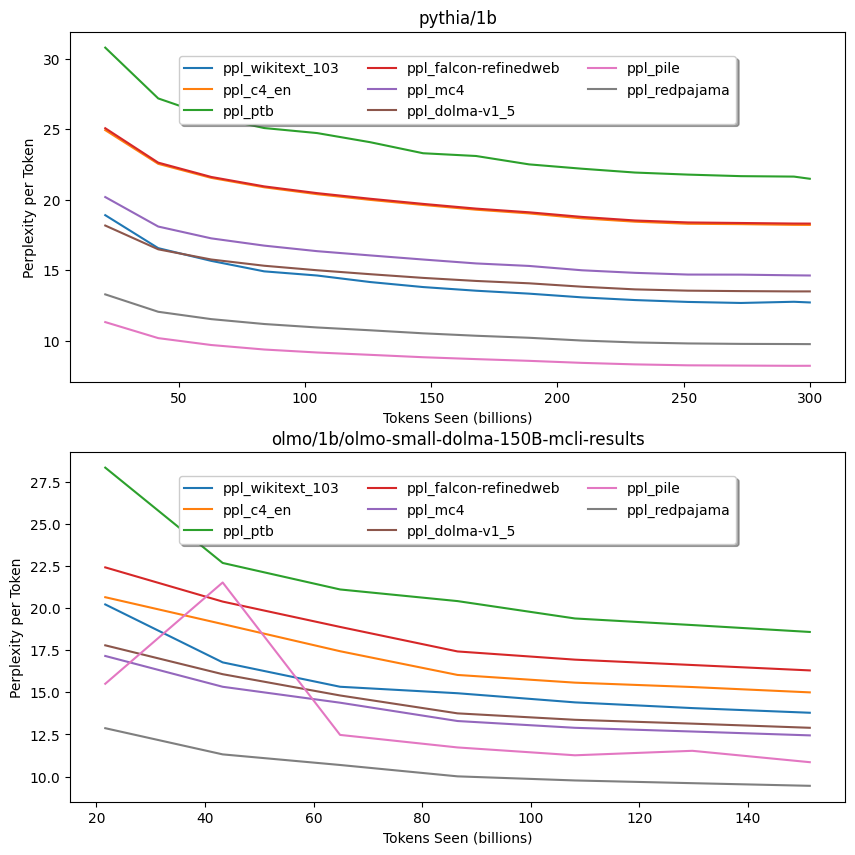

In [119]:
# one subplot per model, with lines for each standard LM benchmark
standard_lm_benchmarks = {
    'ppl_c4_en',
    'ppl_falcon-refinedweb',
    'ppl_mc4',
    'ppl_ptb',
    'ppl_wikitext_103'
}

tasks_and_subdomain_reweighting = {
    'ppl_dolma-v1_5': {'books': 1/6, 'common-crawl': 1/6, 'pes2o': 1/6, 'reddit_uniform': 1/6, 'stack_uniform': 1/6, 'wiki': 1/6}, #temporary weights
    'ppl_pile': {
                    'ArXiv': 0.0896,
                    'BookCorpus2': 0.0075,
                    'Books3': 0.1207,
                    'DM_Mathematics': 0.0124,
                    'Enron_Emails': 0.0014,
                    'EuroParl': 0.0073,
                    'FreeLaw': 0.0612,
                    'Github': 0.0759,
                    'Gutenberg_PG-19': 0.0217,
                    'HackerNews': 0.0062,
                    'NIH_ExPorter': 0.0030,
                    'OpenSubtitles': 0.0155,
                    'OpenWebText2': 0.1001,
                    'PhilPapers': 0.0038,
                    'Pile-CC': 0.1811,
                    'PubMed_Abstracts': 0.0307,
                    'PubMed_Central': 0.1440,
                    'StackExchange': 0.0513,
                    'USPTO_Backgrounds': 0.0365,
                    'Ubuntu_IRC': 0.0088,
                    'Wikipedia_en': 0.0153,
                    'YoutubeSubtitles': 0.0060
                },
    'ppl_redpajama': {'arxiv': 28 / 1210, 'books': 26 / 1210, 'c4': 175 / 1210, 'commoncrawl': 878 / 1210, 'github': 59 / 1210, 'stackexchange': 20 / 1210, 'wikipedia': 24 / 1210}
}

models = [
    "pythia/1b",
    "olmo/1b/olmo-small-dolma-150B-mcli-results"
]

import matplotlib.pyplot as plt
import numpy as np



# one subplot for each model
fig, axs = plt.subplots(len(models), figsize=(10, 10))

# line chare for each model
for i, model in enumerate(models):
    model_path = os.path.join(RESULTS_DIR, model)
    reweighted_tasks_with_subdomains = []
    for task, reweighting in tasks_and_subdomain_reweighting.items():
        task_df = get_metric_for_all_subdomains(model_path, ['ppl_token_'+task+'_subdomains.jsonl.gz'], 'ppl_token')
        reweighted_tasks_with_subdomains.append(get_metric_weighted_by_subdomains(task_df, reweighting, task))
    all_subdomains = get_metric_for_all_subdomains(model_path, [], 'ppl_token', standard_lm_benchmarks, reweighted_tasks_with_subdomains)
    for subdomain in list(standard_lm_benchmarks) + list(tasks_and_subdomain_reweighting.keys()):
        x_axis = all_subdomains['tokens_seen'] / 1000000000
        y_axis = all_subdomains[subdomain]
        axs[i].plot(x_axis, y_axis, label=subdomain)
    axs[i].set_xlabel("Tokens Seen (billions)")
    axs[i].set_ylabel("Perplexity per Token")
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, .95),
          ncol=3, fancybox=True, shadow=True)
    axs[i].set_title(model)
plt.show()

# output as pdf
fig.savefig(os.path.join(FIGURE_DIR,'standard_benchmarks_by_models.pdf'), bbox_inches='tight', dpi=300)


In [138]:
# table with a column for each standard benchmark, where cells are final model checkpoints ranked by their perplexity on that benchmark
# line chare for each model
all_subdomains = []
for i, model in enumerate(models):
    model_path = os.path.join(RESULTS_DIR, model)
    reweighted_tasks_with_subdomains = []
    for task, reweighting in tasks_and_subdomain_reweighting.items():
        task_df = get_metric_for_all_subdomains(model_path, ['ppl_token_'+task+'_subdomains.jsonl.gz'], 'ppl_token')
        reweighted_tasks_with_subdomains.append(get_metric_weighted_by_subdomains(task_df, reweighting, task))
    all_subdomains.append(get_metric_for_all_subdomains(model_path, [], 'ppl_token', standard_lm_benchmarks, reweighted_tasks_with_subdomains))
all_subdomains = pd.concat(all_subdomains)

# get just the final checkpoints by tokens seen for each model
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby('model').last().reset_index()

rankings_by_benchmark = {}
for benchmark in set(all_subdomains.columns) - shared_cols:
    rankings_by_benchmark[benchmark] = all_subdomains.sort_values(by=[benchmark])['model'].reset_index(drop=True)

rankings_by_benchmark_df = pd.DataFrame(rankings_by_benchmark)
rankings_by_benchmark_df.reset_index(drop=True)
rankings_by_benchmark_df.rename(columns=name_to_display, inplace=True)

# output as latex
rankings_by_benchmark_df.to_latex(os.path.join(TABLES_DIR, 'standard_benchmarks_by_models.tex'), index=False)
rankings_by_benchmark_df

,PTB,RedPajama,Dolma V1.5,WikiText-103,C4,The Pile,Falcon,MC4
0,olmo,olmo,olmo,pythia,olmo,pythia,olmo,olmo
1,pythia,pythia,pythia,olmo,pythia,olmo,pythia,pythia


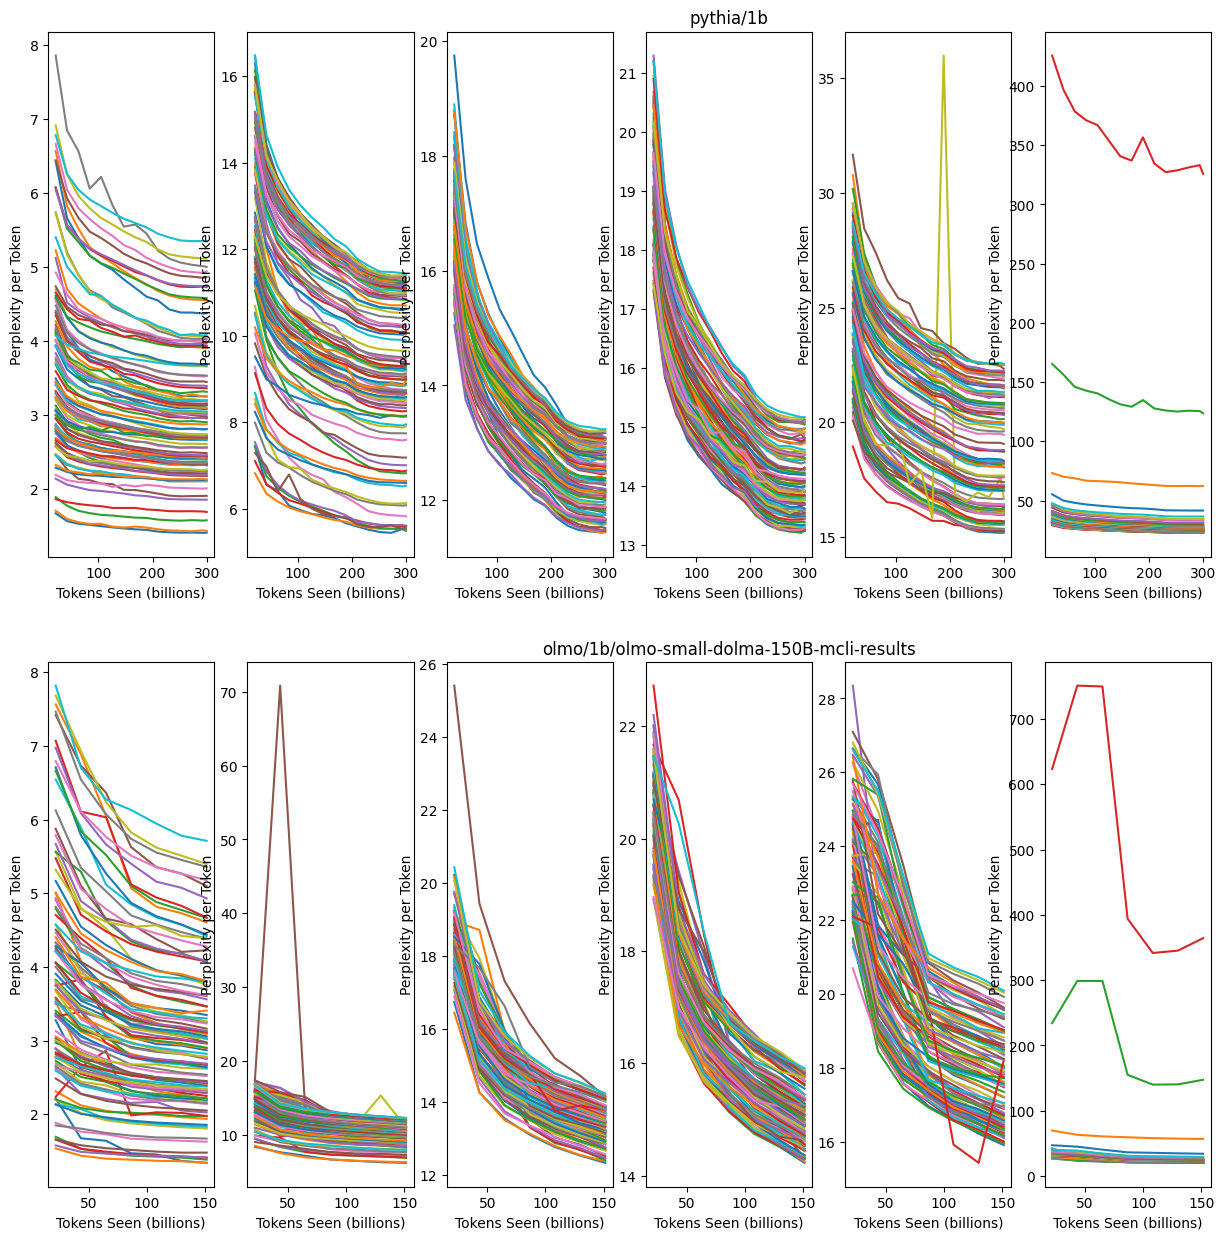

In [140]:
# one subplot per model, with lines for each subdomain

models = [
    "pythia/1b",
    "olmo/1b/olmo-small-dolma-150B-mcli-results"
]

import matplotlib.pyplot as plt
import numpy as np



# one subplot for each model
fig, axs = plt.subplots(len(models), 6, figsize=(15, 15))

# line chare for each model
for i, model in enumerate(models):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
    max_tokens_seen_row = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True).drop(columns=shared_cols).T.rename(columns={0: 'metric'})
    domains_by_final_ppl = list(max_tokens_seen_row.sort_values(by='metric', axis=0).index)
    
    for j in range(6):
        for subdomain in domains_by_final_ppl[j*100:j*100+100]:
            x_axis = all_subdomains['tokens_seen'] / 1000000000
            y_axis = all_subdomains[subdomain]
            axs[i][j].plot(x_axis, y_axis, label=subdomain)
        axs[i][j].set_xlabel("Tokens Seen (billions)")
        axs[i][j].set_ylabel("Perplexity per Token")
    # axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, .95),
    #       ncol=3, fancybox=True, shadow=True)
    axs[i][3].set_title(model)
plt.show()

fig.savefig(os.path.join(FIGURE_DIR,'curves_for_all_subdomains.pdf'), bbox_inches='tight', dpi=300)


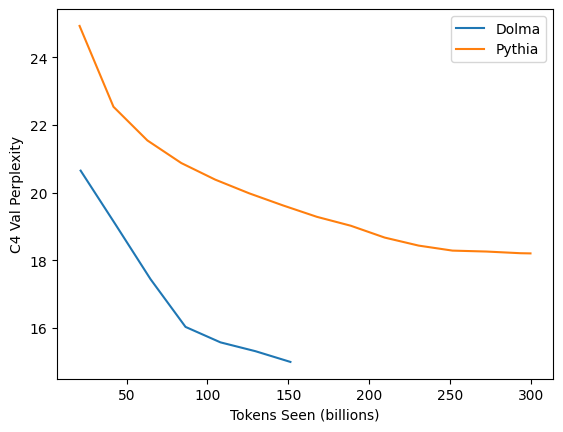

In [67]:
# just c4 
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_ppl_token_all_domains_avg = get_avg_over_all_subdomains(get_metric_for_all_subdomains(model_path, [], 'ppl_token', {'ppl_c4_en'}))

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_ppl_token_all_domains_avg = get_avg_over_all_subdomains(get_metric_for_all_subdomains(model_path, [], 'ppl_token', {'ppl_c4_en'}))

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = dolma_ppl_token_all_domains_avg['tokens_seen'] / 1000000000
dolma_y_axis = dolma_ppl_token_all_domains_avg['avg_over_subdomains']

pythia_x_axis = pythia_ppl_token_all_domains_avg['tokens_seen'] / 1000000000
pythia_y_axis = pythia_ppl_token_all_domains_avg['avg_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("C4 Val Perplexity")
plt.legend()
plt.show()

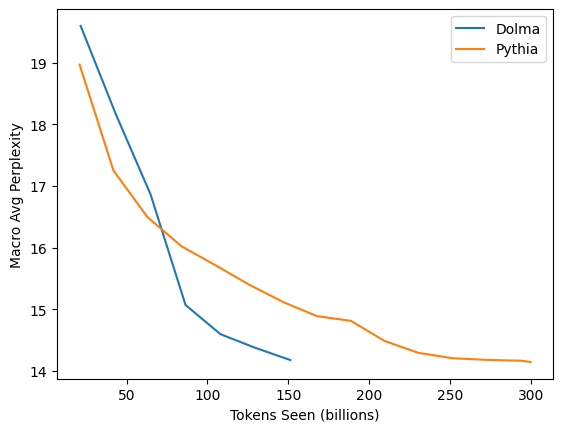

In [5]:
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_ppl_token_all_domains_avg = get_avg_over_all_subdomains(get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean))

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_ppl_token_all_domains_avg = get_avg_over_all_subdomains(get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean))

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = dolma_ppl_token_all_domains_avg['tokens_seen'] / 1000000000
dolma_y_axis = dolma_ppl_token_all_domains_avg['avg_over_subdomains']

pythia_x_axis = pythia_ppl_token_all_domains_avg['tokens_seen'] / 1000000000
pythia_y_axis = pythia_ppl_token_all_domains_avg['avg_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Macro Avg Perplexity")
plt.legend()
plt.show()

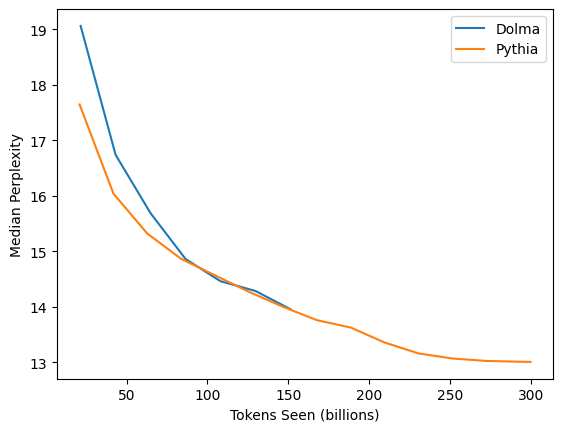

In [4]:
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_ppl_token_all_domains_median = get_median_over_all_subdomains(get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean))

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_ppl_token_all_domains_median = get_median_over_all_subdomains(get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean))

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = dolma_ppl_token_all_domains_median['tokens_seen'] / 1000000000
dolma_y_axis = dolma_ppl_token_all_domains_median['median_over_subdomains']

pythia_x_axis = pythia_ppl_token_all_domains_median['tokens_seen'] / 1000000000
pythia_y_axis = pythia_ppl_token_all_domains_median['median_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Median Perplexity")
plt.legend()
plt.show()

<Axes: >

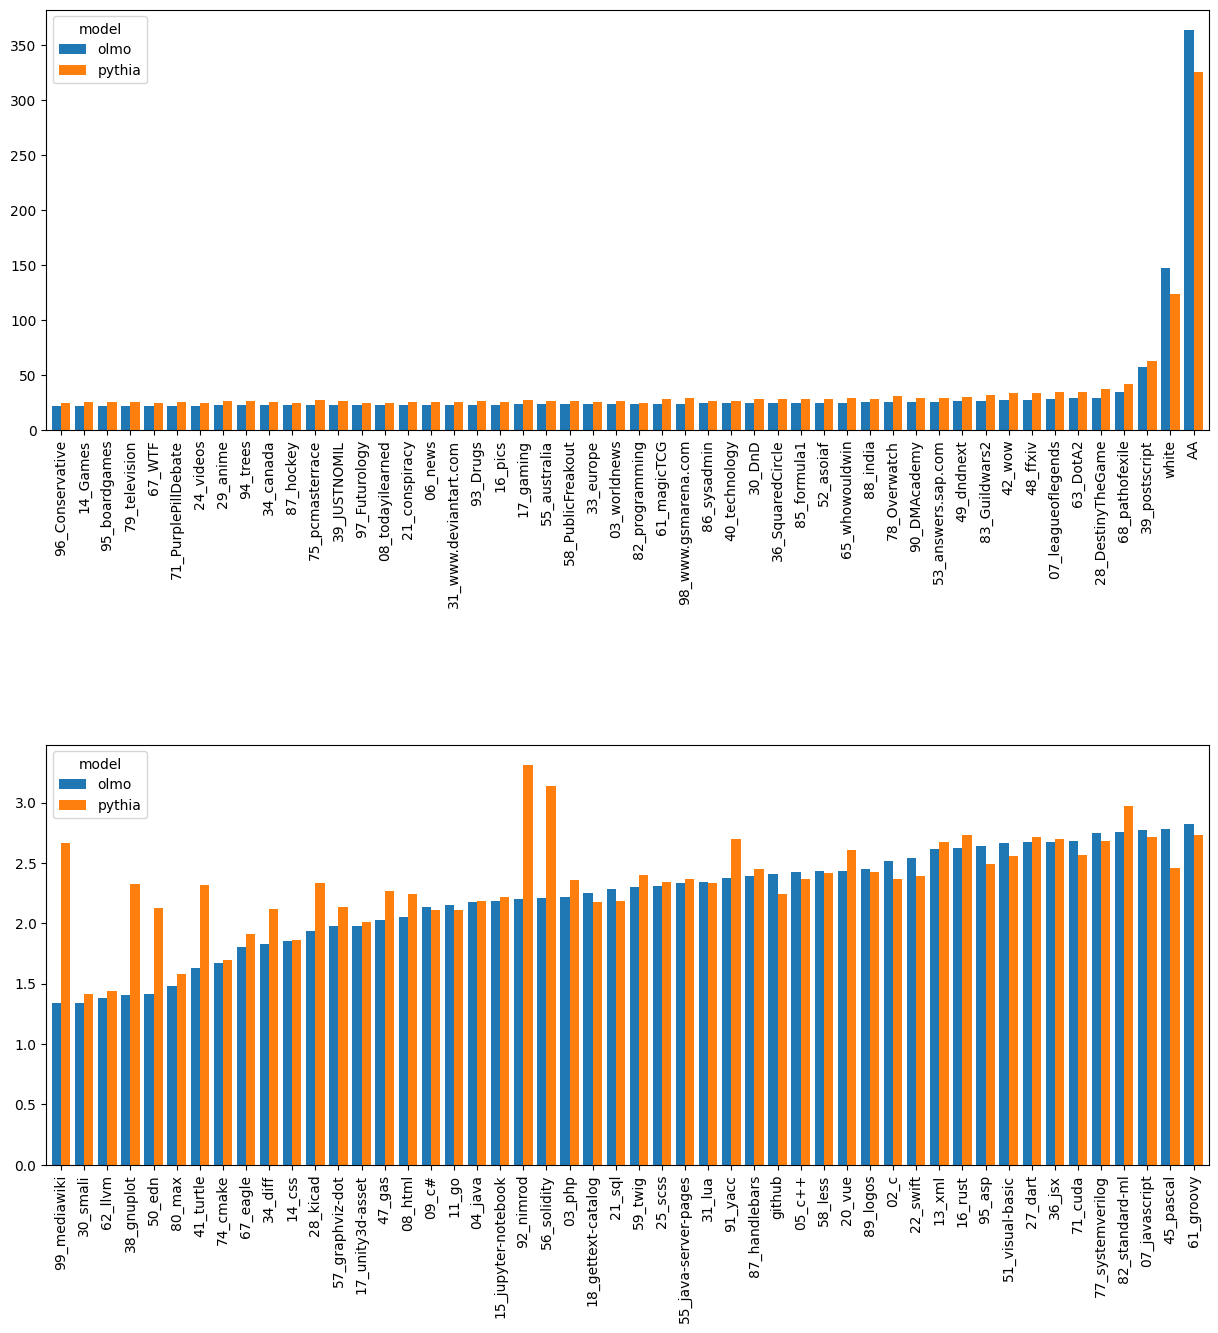

In [53]:
# bar chart over domains (no labels) of final dolma and pythia model

# bar chart of win rate over all final models
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])

# get the max 'tokens_seen' for each model
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby('model').last().reset_index()

# sort domain columns by perplexity for dolma
dolma_domains_as_rows = all_subdomains[all_subdomains['model'] == 'olmo'].drop(columns=shared_cols).T.rename(columns={0: 'metric'})
domains_by_dolma_ppl = list(dolma_domains_as_rows.sort_values(by='metric', axis=0).index)


# bar chart over domains for both models


# make 3 subplots with more space between plts
fig, axs = plt.subplots(2, 1, figsize=(15, 15), gridspec_kw={'hspace': 0.75})
# ax = domain_data_by_dolma_order.T.plot.bar(width=.8)
# in first subplot, plot the top 50 domains by dolma ppl
domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl[-50:]].set_index('model')
domain_data_by_dolma_order.T.plot.bar(width=.8, ax=axs[0])

domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl[:50]].set_index('model')
domain_data_by_dolma_order.T.plot.bar(width=.8, ax=axs[1])



(0.0, 50.0)

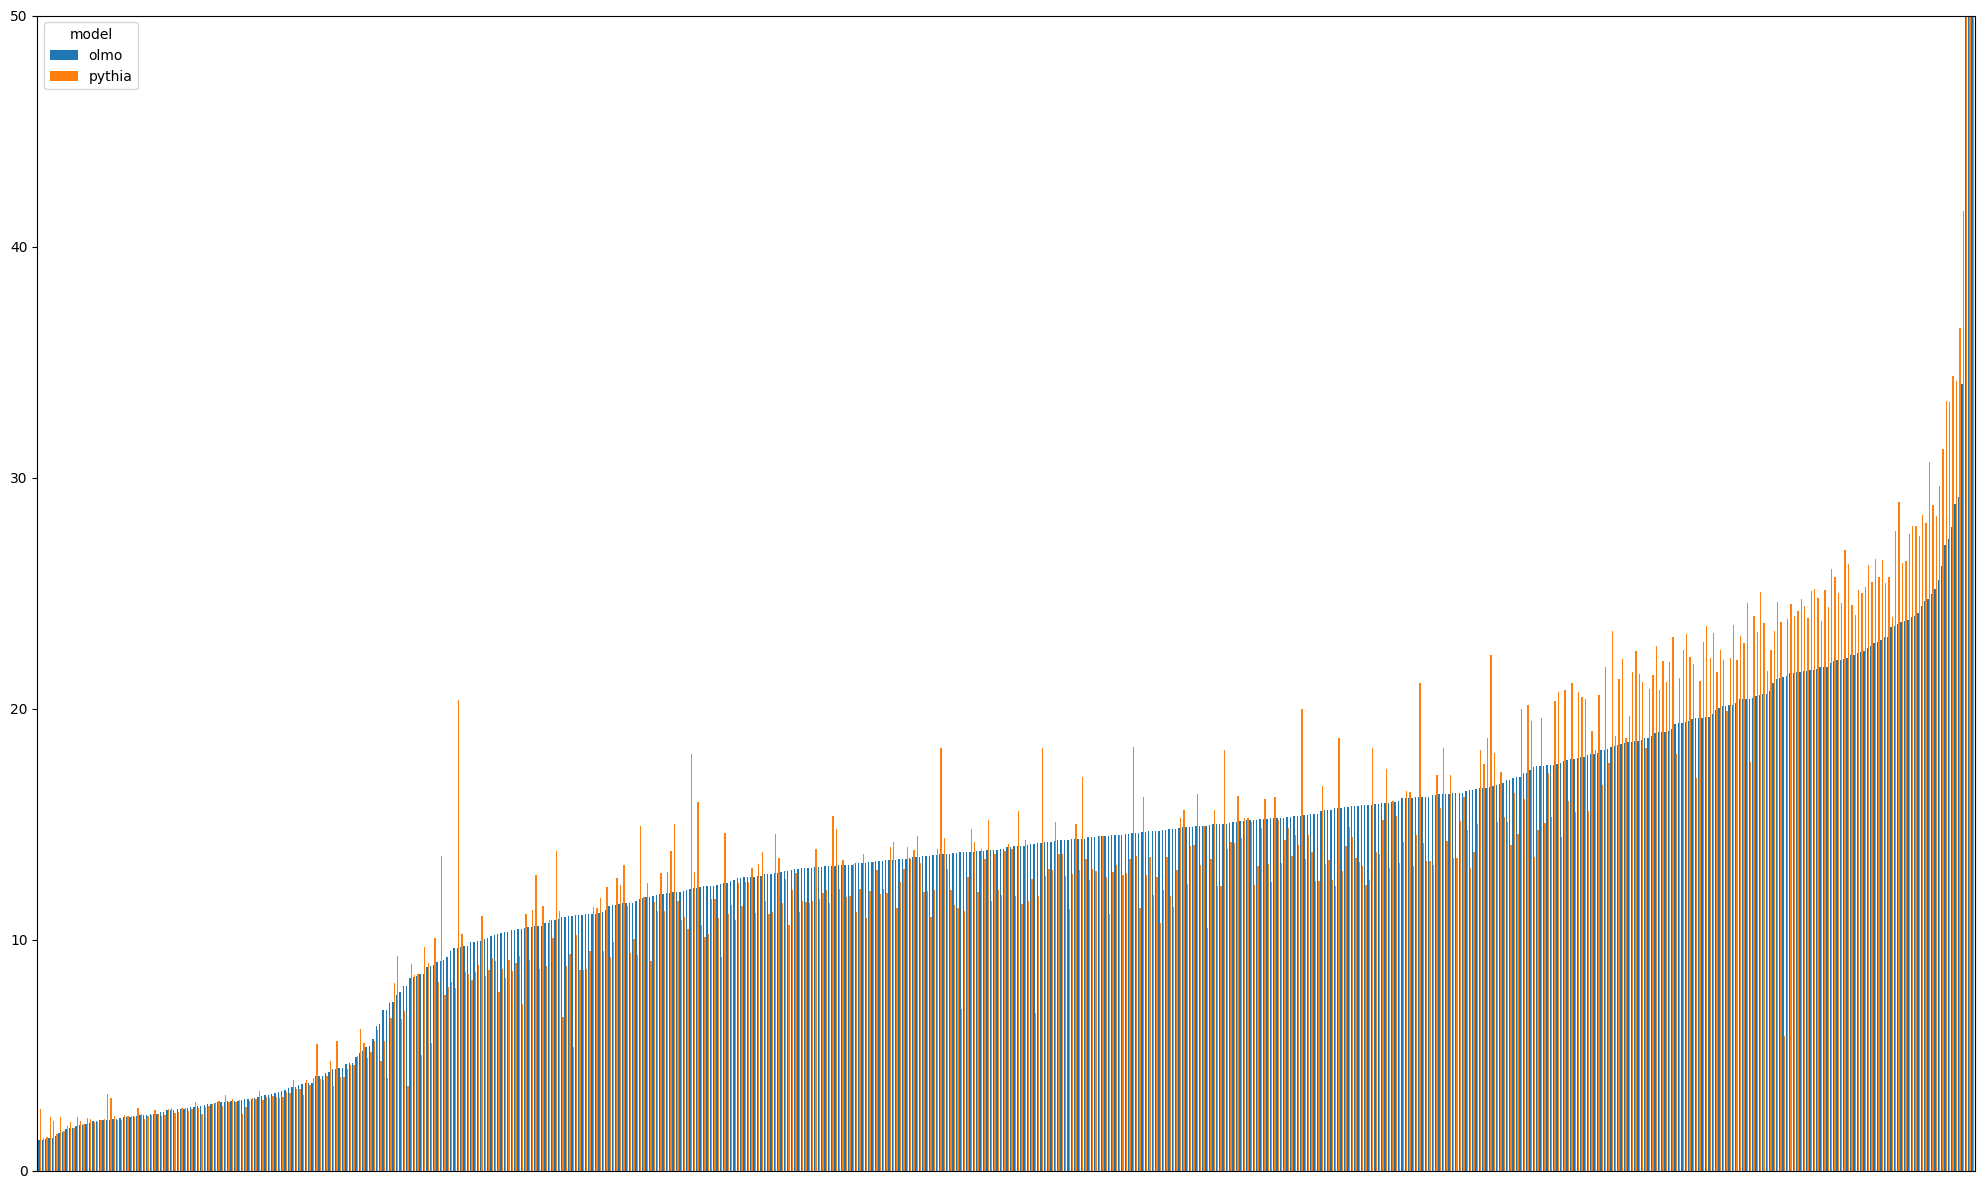

In [66]:
domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl].set_index('model')
ax = domain_data_by_dolma_order.T.plot.bar(width=.8, figsize=(25, 15))
# remove the x axis labels for the last plot
ax.set_xticklabels([])
# remove the x ticks too
ax.set_xticks([])
# y limit
ax.set_ylim([0, 50])

<BarContainer object of 2 artists>

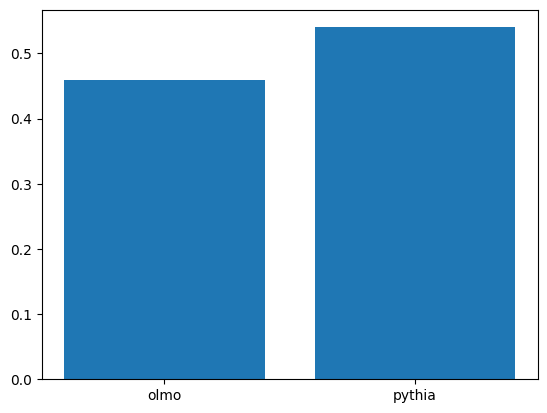

In [6]:
# bar chart of win rate over all final models
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])

# get the max 'tokens_seen' for each model
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby('model').last().reset_index()
win_rate = get_win_rate_over_all_subdomains(all_subdomains)

# make a bar chart of the win rate
win_rate = win_rate.sort_values(by=['win_rate_over_subdomains'])
plt.bar(win_rate['model'], win_rate['win_rate_over_subdomains'])

In [194]:
# a table ranking models by macro avg or win rate over subdomains from given tasks

def get_task_subdomains_results_files(results_files, metric_name, task_name):
    return [f for f in results_files if f.startswith(metric_name) and f.endswith(task_name + '_subdomains.jsonl.gz')]

tasks_to_files = {
    task: get_task_subdomains_results_files(results_files_clean, 'ppl_token', task) for task in domains_with_subdomains_clean
}
tasks_to_files['All'] = results_files_clean

def make_ranking_table(agg_function, metric_name, models, tasks_to_files):
    assert agg_function in {get_avg_over_all_subdomains, get_win_rate_over_all_subdomains}
    all_dfs = []
    for task, files in tasks_to_files.items():
        all_models_dfs = []
        for i, model in enumerate(models):
            model_path = os.path.join(RESULTS_DIR, model)
            task_all_subdomains = get_metric_for_all_subdomains(model_path, files, metric_name)
            # get just the final checkpoints by tokens seen for each model
            all_models_dfs.append(task_all_subdomains.sort_values(by=['tokens_seen']).groupby('model').last().reset_index())
        all_models_dfs = pd.concat(all_models_dfs)
        all_models_dfs = agg_function(all_models_dfs)
        if 'avg_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'avg_over_subdomains': task}, inplace=True)
        if 'win_rate_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'win_rate_over_subdomains': task}, inplace=True)
        all_dfs.append(all_models_dfs)
    all_dfs = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), all_dfs)

    return all_dfs

    # rankings_by_benchmark = {}
    # for benchmark in set(all_subdomains.columns) - shared_cols:
    #     rankings_by_benchmark[benchmark] = all_subdomains.sort_values(by=[benchmark])['model'].reset_index(drop=True)

    # rankings_by_benchmark_df = pd.DataFrame(rankings_by_benchmark)
    # rankings_by_benchmark_df.reset_index(drop=True)
    # rankings_by_benchmark_df.rename(columns=name_to_display, inplace=True)

    # # output as latex
    # rankings_by_benchmark_df.to_latex(os.path.join(TABLES_DIR, 'standard_benchmarks_by_models.tex'), index=False)
    # return rankings_by_benchmark_df
    


In [210]:
rankings_table = make_ranking_table(get_win_rate_over_all_subdomains, 'ppl_token', models, tasks_to_files).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_win_rates_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format)
rankings_table

,Model Size,Training Dataset,Model,100 PLs,RedPajama,M2D2 S2ORC,Dolma V1.5,M2D2 Wikipedia,ICE,Twitter AAE,The Pile,100 Subreddits,C4 100 Domains,All
0,805736448,The Pile,pythia,0.51,0.714286,1.0,0.5,0.877551,0.411765,1.0,1.0,0.0,0.090909,0.543058
1,1177240704,Dolma V1.5,olmo,0.49,0.285714,0.0,0.5,0.122449,0.588235,0.0,0.0,1.0,0.909091,0.456942


In [211]:
rankings_table = make_ranking_table(get_avg_over_all_subdomains, 'ppl_token', models, tasks_to_files).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_avg_ppl_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format)
rankings_table

,Model Size,Training Dataset,Model,100 PLs,RedPajama,M2D2 S2ORC,Dolma V1.5,M2D2 Wikipedia,ICE,Twitter AAE,The Pile,100 Subreddits,C4 100 Domains,All
0,805736448,The Pile,pythia,3.749775,8.662201,12.339637,13.491730,12.654877,15.445682,224.727703,8.265756,24.558751,15.015606,14.118929
1,1177240704,Dolma V1.5,olmo,3.611867,9.607313,14.206025,12.894585,13.399320,15.505382,255.769212,12.137852,21.384195,13.579961,14.164810


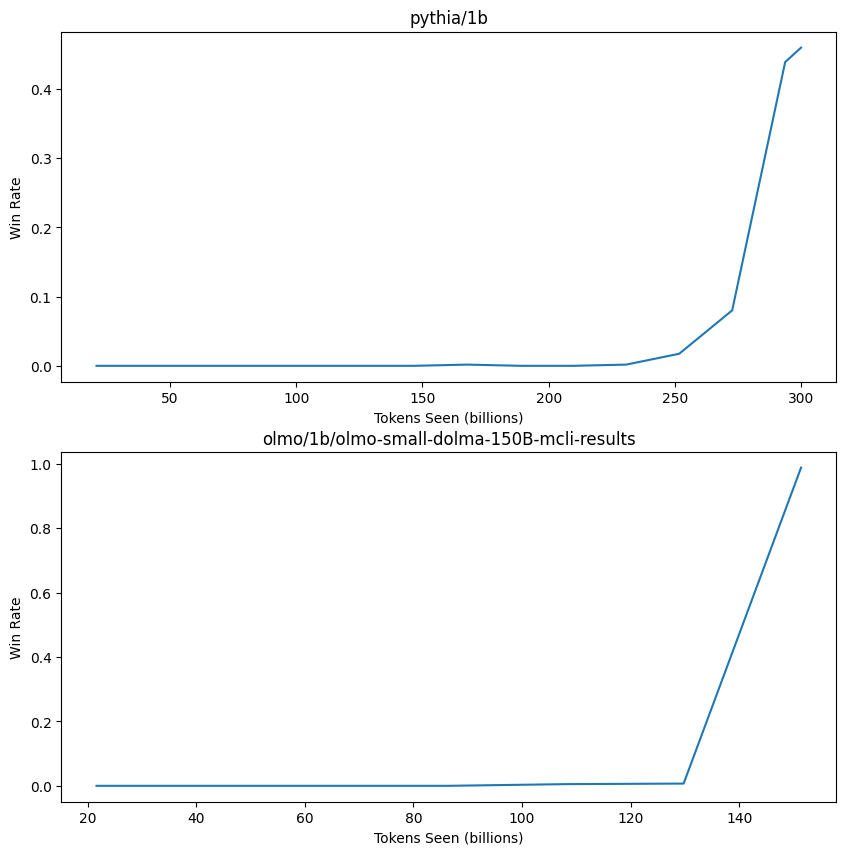

In [7]:
# win rate over training progress for each model seperately
models = [
    "pythia/1b",
    "olmo/1b/olmo-small-dolma-150B-mcli-results"
]

import matplotlib.pyplot as plt
import numpy as np

# one subplot for each model
fig, axs = plt.subplots(len(models), figsize=(10, 10))

# line chare for each model
for i, model in enumerate(models):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
    win_rate = get_win_rate_over_all_subdomains(all_subdomains)
    x_axis = win_rate['tokens_seen'] / 1000000000
    y_axis = win_rate['win_rate_over_subdomains']
    axs[i].plot(x_axis, y_axis)
    axs[i].set_title(model)
    axs[i].set_xlabel("Tokens Seen (billions)")
    axs[i].set_ylabel("Win Rate")

plt.show()



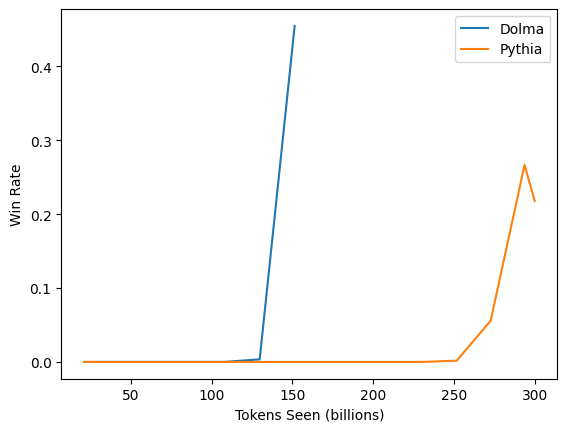

In [8]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains(all_subdomains)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['tokens_seen'] / 1000000000
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_over_subdomains']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['tokens_seen'] / 1000000000
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Win Rate")
plt.legend()
plt.show()



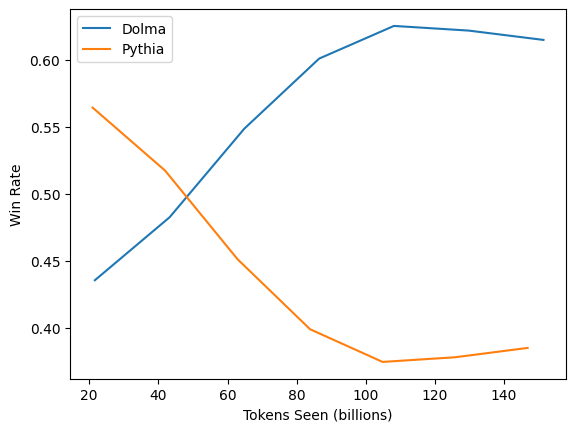

In [9]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains_by_nearest(all_subdomains, 'tokens_seen', 10000000000)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['tokens_seen'] / 1000000000
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_with_nearest']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['tokens_seen'] / 1000000000
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_with_nearest']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

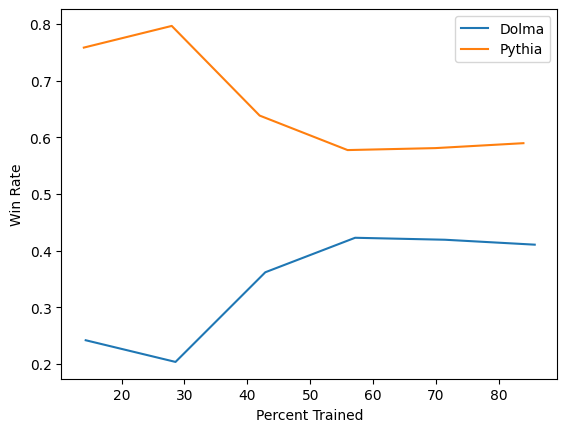

In [10]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
pythia_all_subdomains['percent_trained'] = pythia_all_subdomains['training_steps'] / pythia_all_subdomains['training_steps'].max()

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
dolma_all_subdomains['percent_trained'] = dolma_all_subdomains['training_steps'] / dolma_all_subdomains['training_steps'].max()

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains_by_nearest(all_subdomains, 'percent_trained', .2)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['percent_trained'] * 100
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_with_nearest']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['percent_trained'] * 100
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_with_nearest']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Percent Trained")
plt.ylabel("Win Rate")
plt.legend()
plt.show()